In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

import numpy as np
import pandas as pd 
import json

import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

from transformers import BertTokenizer, get_linear_schedule_with_warmup

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import matthews_corrcoef, confusion_matrix

import random
import wandb

import sys
sys.path.append('/home/inaki/host_data')
import models
from utils import train_loop, evaluate, evaluate_kfold_ensemble
from CreateDataset import BertDataset

In [2]:
###############################
#       configuración         #
###############################
MODEL_NAME = "BertBasePooledOutput"

MAX_LENGTH = 512
HEAD_DROPOUT = 0.0
DATA_AUGMENTATION = [] #["Oversampling"] # '_es_into_en' # 'llama_aug'
FOLDS_NUM = 10

NUM_EPOCHS = 5
LEARNING_RATE = 2e-5
BATCH_SIZE = 16
DECAY = 0

LOSS_FN =  'supervised_contrastive' # 'cross_entropy' # 'supervised_contrastive'

temperature = 0.3  # temprature for contrastive loss
lam = 0.9  # lambda for loss

checkoint_folder = 'Baseline'

datadir = "/home/inaki/host_data/dataset_oppositional/"
cuda_device = 0
wandb_project = 'epoch_analysis'    # 'BASELINE'  'Ensemble_baseline'  'trash'  'epoch_analysis'

In [3]:
!nvidia-smi

Sat May 11 22:17:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:01:00.0 Off |                  N/A |
|  0%   50C    P5              66W / 370W |   3434MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
# Cargamos los datasets de entrenamiento y test
train_en_dataset_path = datadir + "train_en_data.pth"
X, y = torch.load(train_en_dataset_path)
X = np.array(X)
y = np.array(y)
train_en_dataset = BertDataset(X, y)

# Obtén la referencia a la clase del módulo models
ModelClass = getattr(models, MODEL_NAME)
model = ModelClass(dropout_prob=HEAD_DROPOUT)

device = torch.device(f"cuda:{cuda_device}" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
for param in model.parameters():
    param.requires_grad = True

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


cuda:0


In [6]:
dataloader = DataLoader(train_en_dataset, batch_size=5, shuffle=False)
input_ids, attention_mask, labels, _ = dataloader.__iter__().__next__()
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
labels = labels.to(device)
print(labels)

tensor([0, 1, 0, 0, 0], device='cuda:0')


In [7]:
positive = BertDataset(X[y == 1], y[y == 1])
negative = BertDataset(X[y == 0], y[y == 0])

def get_mixup_batch(positive, negative, labels):
    input_ids, attention_masks, mixup_labels = [], [], []
    for label in labels.tolist():
        if label == 0:
            input_id, attention_mask, label, _ = positive[np.random.randint(0, len(positive))]
        else:
            input_id, attention_mask, label, _ = negative[np.random.randint(0, len(negative))]
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        mixup_labels.append(label)

    return [torch.stack(input_ids), torch.stack(attention_masks), torch.tensor(mixup_labels)]

In [8]:
mixup_input_ids, mixup_attention_masks, mixup_labels = get_mixup_batch(positive, negative, labels)
mixup_input_ids = mixup_input_ids.to(device)
mixup_attention_masks = mixup_attention_masks.to(device)
mixup_labels = mixup_labels.to(device)

In [22]:
def mix_labels(labels, mixup_labels, alfa=0.3):
    beta = torch.tensor([np.random.beta(alfa, alfa) for _ in range(len(labels))]).reshape(-1, 1)
    beta = beta.to(device)
    return  beta, beta * labels + (1 - beta) * mixup_labels

In [24]:
beta, mixed_labels = mix_labels(labels, mixup_labels, alfa=0.3)

print(beta)
print(mixed_labels)

tensor([[0.0707],
        [0.0445],
        [0.0903],
        [0.0010],
        [0.0012]], device='cuda:0')
tensor([[9.2932e-01, 7.0678e-02, 9.2932e-01, 9.2932e-01, 9.2932e-01],
        [9.5549e-01, 4.4509e-02, 9.5549e-01, 9.5549e-01, 9.5549e-01],
        [9.0967e-01, 9.0327e-02, 9.0967e-01, 9.0967e-01, 9.0967e-01],
        [9.9904e-01, 9.5974e-04, 9.9904e-01, 9.9904e-01, 9.9904e-01],
        [9.9878e-01, 1.2226e-03, 9.9878e-01, 9.9878e-01, 9.9878e-01]],
       device='cuda:0')


In [ ]:
mixup_emb, mix_logits = model.mixup_forward(input_ids, attention_mask, mixup_input_ids, mixup_attention_masks, beta)

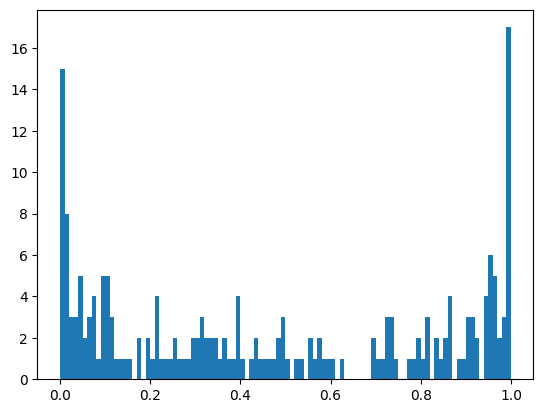

In [83]:
beta_f = [np.random.beta(0.4, 0.4) for _ in range(200)]
plot = plt.hist(beta_f, bins=100)

In [11]:

temp = 0.3
dataloader = DataLoader(train_en_dataset, batch_size=5, shuffle=False)
input_ids, attention_mask, labels, _ = dataloader.__iter__().__next__()
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
labels = labels.to(device)

embedding, logit = model(input_ids, attention_mask)

norm_L2 = torch.norm(embedding, p=2, dim=1, keepdim=True)
print(norm_L2)

# cosine similarity between embeddings
cosine_sim = torch.nn.functional.cosine_similarity(embedding.unsqueeze(1), embedding.unsqueeze(0), dim=2)
print(cosine_sim)


#print(dis)

# apply temperature to elements
dis = dis / temp
#print(dis)
cosine_sim = cosine_sim / temp

# apply exp to elements
dis = torch.exp(dis)
print(dis)
cosine_sim = torch.exp(cosine_sim)
# calculate row sum
row_sum = dis.sum(dim=1)
print(row_sum)

# calculate outer sum
contrastive_loss = 0
print(labels)
for i in range(len(embedding)):
    n_i = (labels == labels[i]).sum().item() - 1
    print(n_i)
    inner_sum = 0
"""
    # calculate inner sum
    for j in range(len(embedding)):
        if label[i] == label[j] and i != j:
            inner_sum = inner_sum + torch.log(cosine_sim[i][j] / row_sum[i])
    if n_i != 0:
        contrastive_loss += (inner_sum / (-n_i))
    else:
        contrastive_loss += 0
"""

tensor([[19.1925],
        [18.4902],
        [15.5536],
        [18.8394],
        [19.6545]], device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor([[1.0000, 0.9836, 0.9393, 0.9550, 0.9926],
        [0.9836, 1.0000, 0.9403, 0.9510, 0.9715],
        [0.9393, 0.9403, 1.0000, 0.9334, 0.9195],
        [0.9550, 0.9510, 0.9334, 1.0000, 0.9498],
        [0.9926, 0.9715, 0.9195, 0.9498, 1.0000]], device='cuda:0',
       grad_fn=<SumBackward1>)
tensor([[ 1.0000, 26.5409, 22.9002, 24.1306, 27.3483],
        [26.5409,  1.0000, 22.9765, 23.8062, 25.4928],
        [22.9002, 22.9765,  1.0000, 22.4483, 21.4311],
        [24.1306, 23.8062, 22.4483,  1.0000, 23.7140],
        [27.3483, 25.4928, 21.4311, 23.7140,  1.0000]], device='cuda:0',
       grad_fn=<ExpBackward0>)
tensor([101.9200,  99.8164,  90.7561,  95.0991,  98.9863], device='cuda:0',
       grad_fn=<SumBackward1>)
tensor([0, 1, 0, 0, 0], device='cuda:0')
3
0
3
3
3


'\n    # calculate inner sum\n    for j in range(len(embedding)):\n        if label[i] == label[j] and i != j:\n            inner_sum = inner_sum + torch.log(cosine_sim[i][j] / row_sum[i])\n    if n_i != 0:\n        contrastive_loss += (inner_sum / (-n_i))\n    else:\n        contrastive_loss += 0\n'